In [3]:
import pandas as pd
import numpy as np
import re
import networkx as nx
import matplotlib.pyplot as plt
import random
from itertools import combinations
import networkx as nx
from collections import Counter
import ast
import cosmograph as cg
from collections import defaultdict
from pyvis.network import Network
import plotly.graph_objects as go


Put your absolute path to the project here

In [6]:
ABS_PATH = '/Users/mehdibouchoucha/Desktop/ADA/ada-2024-project-theundocumentedanalysts/'

# First Study :

This first study is to find the relation between actor pairs, we first clean the data and keep the important column that are relevant to the subject. The two initial databases, namely "character_metadata" and "movie_metadata".

### Steps :
- We removed the irrelevant columns and merged on the 

In [7]:
character_metadata = pd.read_csv(ABS_PATH+'data/CMU_dataset/character.metadata.tsv', sep='\t')
oscars =pd.read_csv(ABS_PATH+'data/the_oscar_award.csv')
movie_metadata = pd.read_csv(ABS_PATH+'data/CMU_dataset/movie.metadata.tsv', sep='\t')
movie_data = pd.read_csv(ABS_PATH+'data/movie_data.csv')

In [3]:
movie_metadata.columns =['Wikipedia movie ID','Freebase movie ID','Movie name','Movie release date',
                         'Movie box office revenue','Movie runtime','Movie languages',
                        'Movie countries','Movie genres']
print(movie_metadata.columns)

Index(['Wikipedia movie ID', 'Freebase movie ID', 'Movie name',
       'Movie release date', 'Movie box office revenue', 'Movie runtime',
       'Movie languages', 'Movie countries', 'Movie genres'],
      dtype='object')


In [4]:
# Add headers
character_metadata.columns = [
    'Wikipedia movie ID',
    'Freebase movie ID',
    'Movie release date',
    'Character name',
    'Actor date of birth',
    'Actor gender',
    'Actor height (in meters)',
    'Actor ethnicity (Freebase ID)',
    'Actor name',
    'Actor age at movie release',
    'Freebase character/actor map ID',
    'Freebase character ID',
    'Freebase actor ID'
]

# Function to clean the genre column by extracting genre names
def extract_genres(genre_str):
    try:
        genre_dict = ast.literal_eval(genre_str)
        # Extract and join all genre names
        cleaned_genres = '|'.join(genre_dict.values())
        return cleaned_genres
    except (ValueError, SyntaxError):
        return None

movie_metadata['Movie genres'] = movie_metadata['Movie genres'].apply(extract_genres)
print(movie_metadata[['Movie genres']].head())

                                        Movie genres
0        Mystery|Biographical film|Drama|Crime Drama
1                                Crime Fiction|Drama
2    Thriller|Erotic thriller|Psychological thriller
3                                              Drama
4  Short Film|Silent film|Indie|Black-and-white|C...


In [5]:
print(character_metadata.shape)
print(movie_metadata.shape)

merged_movie_character = pd.merge(character_metadata, movie_metadata, 
                                  left_on='Wikipedia movie ID', 
                                  right_on='Wikipedia movie ID', 
                                  how='inner')
merged_movie_character.shape

#We only lost 16 rows from the merge

(450668, 13)
(81740, 9)


(450652, 21)

In [6]:
merged_movie_character.drop(columns=['Movie languages','Movie countries',
                                     'Freebase character/actor map ID','Freebase character ID','Freebase actor ID',
                                    'Freebase movie ID_y','Freebase movie ID_x'])
merged_movie_character.head(1)

,Wikipedia movie ID,Freebase movie ID_x,Movie release date_x,Character name,Actor date of birth,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor name,Actor age at movie release,...,Freebase character ID,Freebase actor ID,Freebase movie ID_y,Movie name,Movie release date_y,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
0,3196793,/m/08yl5d,2000-02-16,Police Officer,NaN,M,NaN,NaN,Allen Cutler,NaN,...,/m/0lr3z80,/m/0h8pnlw,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",Mystery|Biographical film|Drama|Crime Drama


In [7]:
# Group movies by wikipedia movie ID
movies_grouped = merged_movie_character.groupby('Wikipedia movie ID').agg({
    'Movie genres': 'first',  # Get the first non-NaN value for genres
    'Actor name': lambda x: '|'.join(x.dropna().unique())  # Aggregate all actors for each movie
}).reset_index()

# Get top 50 genres
all_genres = movies_grouped['Movie genres'].dropna().str.split('|').sum()
genre_counts = Counter(all_genres)
top_50_genres = [genre for genre, count in genre_counts.most_common(50)]

# Filter by top 50 genres
filtered_movies = movies_grouped[movies_grouped['Movie genres'].apply(lambda genres: any(g in top_50_genres for g in genres.split('|')))]

In [14]:
#Generate Actor Pairs from Filtered Movies
actor_pairs = []

for _, row in filtered_movies.iterrows():
    actors = row['Actor name']

    # Skip if actors are nan
    if pd.isna(actors):
        continue

    actors_list = actors.split('|') if isinstance(actors, str) else actors

    # Generate all possible pairs of actors for the movie
    actor_pairs.extend(list(combinations(actors_list, 2)))

# Count and get 500 top actor pairs
pair_counts = Counter(actor_pairs)
top_pairs = pair_counts.most_common(500)

# Extract nodes, edges and genres
nodes = set()
edges = []
node_genre_map = {}

for (actor1, actor2), count in top_pairs:
    nodes.update([actor1, actor2])
    edges.append((actor1, actor2, count))

    # Determine the genres for the actors
    for _, row in filtered_movies.iterrows():
        genres = row['Movie genres']
        actors = row['Actor name']

        if pd.isna(genres) or pd.isna(actors):
            continue

        genres_list = genres.split('|')
        actors_list = actors.split('|') if isinstance(actors, str) else actors

        if actor1 in actors_list or actor2 in actors_list:
            relevant_genres = [genre for genre in genres_list if genre in top_50_genres]
            if actor1 not in node_genre_map:
                node_genre_map[actor1] = relevant_genres[0] if relevant_genres else 'Other'
            if actor2 not in node_genre_map:
                node_genre_map[actor2] = relevant_genres[0] if relevant_genres else 'Other'

genre_colors = {genre: f'#{random.randint(0, 0xFFFFFF):06x}' for genre in top_50_genres}
default_color = '#999999'

# Initialize the Pyvis network
net = Network(notebook=True, height='750px', width='100%', bgcolor='#222222', font_color='white')

# Add nodes to the network with genre-based colors
for node in nodes:
    genre = node_genre_map.get(node, 'Other')
    color = genre_colors.get(genre, default_color)
    net.add_node(node, label=node, color=color)

# Add edges to the network with labels for frequency
for source, target, weight in edges:
    net.add_edge(source, target, value=weight, title=f'Collaborations: {weight}')

# Visualization
net.show("actor_collaboration_filtered_genre_optimized.html")

actor_collaboration_filtered_genre_optimized.html


# Conclusion on this study :

We have shown that it is possible to find the relations between actor pairs based on genre, we can and will finetune this study to apply it to top grossing movies and best actors based on oscars in future milestones.

## Additional findings :

In order to better observe this graph in a more interactive way, we can use the cosmograph application which takes up to 1 million nodes and can gives us better indication since it will target a bigger sample, this proposition is still in progress and we are researching how we could implement it.

# Possible behavior in additional datasets :

### For Movie DATA :
merge movie and character metadata based on wikipedia movie id then select only relevant columns, then merge with additional movie data based on movie names (verify how many rows dropped and if result is coherent or not too many movies in common.) keep some columns and iMDB score. Maybe compare the correlation between imdb score and gross revenu and then maybe between country take the mean score ( of course take into account the number of movies per country for a better study). Age could also be a factor if we decide that experienced actors make better movies or younger actors in their 20s attract the population more ?

### For oscars data :
Press on the hypothesis that younger actors make better movies or younger ones and merge with the oscar data set and do some plots for visualisartion


In [111]:
movie_data.drop(columns=['index','num_voted_users','movie_imdb_link','title_year'])
movie_data.head()

,index,director_name,duration,actor_2_name,genres,actor_1_name,movie_title,num_voted_users,actor_3_name,movie_imdb_link,num_user_for_reviews,language,country,title_year,imdb_score
0,0,James Cameron,178.0,Joel David Moore,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,886204,Wes Studi,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,3054.0,English,USA,2009.0,7.9
1,1,Gore Verbinski,169.0,Orlando Bloom,Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,471220,Jack Davenport,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,1238.0,English,USA,2007.0,7.1
2,2,Sam Mendes,148.0,Rory Kinnear,Action|Adventure|Thriller,Christoph Waltz,Spectre,275868,Stephanie Sigman,http://www.imdb.com/title/tt2379713/?ref_=fn_t...,994.0,English,UK,2015.0,6.8
3,3,Christopher Nolan,164.0,Christian Bale,Action|Thriller,Tom Hardy,The Dark Knight Rises,1144337,Joseph Gordon-Levitt,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,2701.0,English,USA,2012.0,8.5
4,4,Doug Walker,NaN,Rob Walker,Documentary,Doug Walker,Star Wars: Episode VII - The Force Awakens ...,8,NaN,http://www.imdb.com/title/tt5289954/?ref_=fn_t...,NaN,NaN,NaN,NaN,7.1


In [118]:
#check rows before and after merging
print(movie_data.shape)
print(merged_movie_character.shape)

(5043, 15)
(450652, 21)


In [ ]:
score_movie_character = pd.merge(movie_data,merged_movie_character, left_on ='movie_title',right_on ='Movie name'
                                 ,how = 'inner')
score_movie_character

# Not usable for movie_data_csv

Can't Merge on the basis of movie name 

# Oscar data Study

In [143]:
oscar_data = pd.read_csv('/Users/sami.amrouche/Data_Science_minor/ada/ada-2024-project-theundocumentedanalysts/data/the_oscar_award.csv')

In [158]:
oscar_movie_character = pd.merge(oscar_data,merged_movie_character, left_on ='film',right_on ='Movie name')

In [ ]:
#only keep actors and actresses
filtered_oscar_data = oscar_movie_character[oscar_movie_character['category'].str.contains('ACTRESS|ACTOR', case=False, na=False)]
print(filtered_oscar_data.shape)

In [162]:
filtered_oscar_data.columns

Index(['year_film', 'year_ceremony', 'ceremony', 'category', 'name', 'film',
       'winner', 'Wikipedia movie ID', 'Freebase movie ID_x',
       'Movie release date_x', 'Character name', 'Actor date of birth',
       'Actor gender', 'Actor height (in meters)',
       'Actor ethnicity (Freebase ID)', 'Actor name',
       'Actor age at movie release', 'Freebase character/actor map ID',
       'Freebase character ID', 'Freebase actor ID', 'Freebase movie ID_y',
       'Movie name', 'Movie release date_y', 'Movie box office revenue',
       'Movie runtime', 'Movie languages', 'Movie countries', 'Movie genres'],
      dtype='object')

In [171]:
filtered_matching_oscar_data = filtered_oscar_data[filtered_oscar_data['name'] == filtered_oscar_data['Actor name']]
filtered_matching_oscar_data.columns

Index(['year_film', 'year_ceremony', 'ceremony', 'category', 'name', 'film',
       'winner', 'Wikipedia movie ID', 'Freebase movie ID_x',
       'Movie release date_x', 'Character name', 'Actor date of birth',
       'Actor gender', 'Actor height (in meters)',
       'Actor ethnicity (Freebase ID)', 'Actor name',
       'Actor age at movie release', 'Freebase character/actor map ID',
       'Freebase character ID', 'Freebase actor ID', 'Freebase movie ID_y',
       'Movie name', 'Movie release date_y', 'Movie box office revenue',
       'Movie runtime', 'Movie languages', 'Movie countries', 'Movie genres'],
      dtype='object')

# Gender analysis in actor winners

Small study to observe an additional variable in average box office revenue


In [177]:
# Count representation of genders in Oscar-winning roles
gender_representation = filtered_matching_oscar_data.groupby(['Actor gender', 'winner']).size().unstack()
print(gender_representation)


winner        False  True
Actor gender             
F               584   156
M               599   158


In [178]:
# Compare average box office revenue between winning actors and actresses
winning_actors = filtered_matching_oscar_data[(filtered_matching_oscar_data['category'].str.contains('ACTOR')) & (filtered_matching_oscar_data['winner'] == True)]
winning_actresses = filtered_matching_oscar_data[(filtered_matching_oscar_data['category'].str.contains('ACTRESS')) & (filtered_matching_oscar_data['winner'] == True)]

avg_revenue_actors = winning_actors['Movie box office revenue'].mean()
avg_revenue_actresses = winning_actresses['Movie box office revenue'].mean()

print(f"Average Box Office Revenue (Actors): {avg_revenue_actors}")
print(f"Average Box Office Revenue (Actresses): {avg_revenue_actresses}")


Average Box Office Revenue (Actors): 91138551.9736842
Average Box Office Revenue (Actresses): 86507486.60185185


# Trend over time 

Small study to see if age and experience are a variable in winning oscars


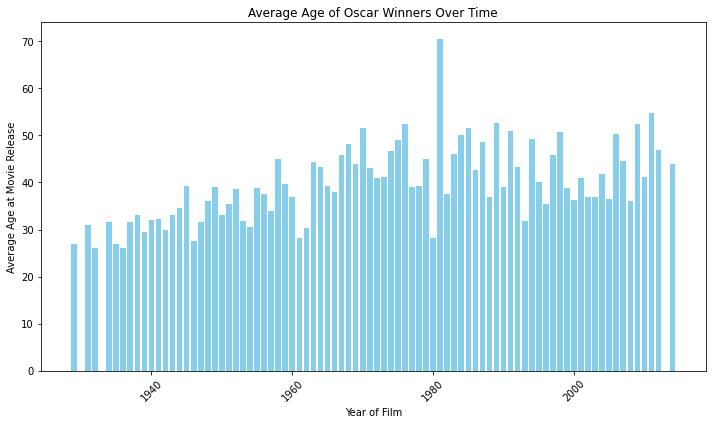

In [174]:
import matplotlib.pyplot as plt

# Filter winning data to include only rows where the 'winner' column is True
winning_data = filtered_matching_oscar_data[filtered_matching_oscar_data['winner'] == True]

avg_age_over_years = winning_data.groupby('year_film')['Actor age at movie release'].mean()

plt.figure(figsize=(10, 6))
plt.bar(avg_age_over_years.index, avg_age_over_years.values, color='skyblue')  # Customize color if desired
plt.xlabel('Year of Film')
plt.ylabel('Average Age at Movie Release')
plt.title('Average Age of Oscar Winners Over Time')

# Display the bar plot
plt.xticks(rotation=45)  
plt.tight_layout()     
plt.show()


# Box office revenue for winning vs non winning oscar movies

In [175]:
# Compare average box office revenue for winning vs. non-winning movies
avg_box_office_winner = filtered_matching_oscar_data[filtered_matching_oscar_data['winner'] == True]['Movie box office revenue'].mean()
avg_box_office_non_winner = filtered_matching_oscar_data[filtered_matching_oscar_data['winner'] == False]['Movie box office revenue'].mean()

print(f"Average Box Office Revenue (Winners): {avg_box_office_winner}")
print(f"Average Box Office Revenue (Non-Winners): {avg_box_office_non_winner}")


Average Box Office Revenue (Winners): 88885601.25225225
Average Box Office Revenue (Non-Winners): 74654348.64332037


# Movie Genre

This is a more general study on movie genre without filtering as in the first study

In [192]:
# Calculate genre frequencies
all_genres = movie_metadata['Movie genres'].dropna().str.split('|').sum()
genre_counts = pd.Series(all_genres).value_counts()

# Define threshold for filtering
min_threshold = 10  
max_threshold = 500  

# Filter genres based on their occurrence count
filtered_genres = genre_counts[(genre_counts > min_threshold) & (genre_counts < max_threshold)].index

# Create filtered genre pairs for graph
filtered_genre_pairs = [pair for pair in genre_pairs if pair[0] in filtered_genres and pair[1] in filtered_genres]

# Create the NetworkX graph
G_filtered = nx.Graph()
G_filtered.add_edges_from(filtered_genre_pairs)


In [193]:
from collections import Counter

pair_counts = Counter(genre_pairs)

top_pairs = [pair for pair, count in pair_counts.most_common(50)]  # Adjust as needed

# Create the graph with only top pairs
G_top_pairs = nx.Graph()
G_top_pairs.add_edges_from(top_pairs)


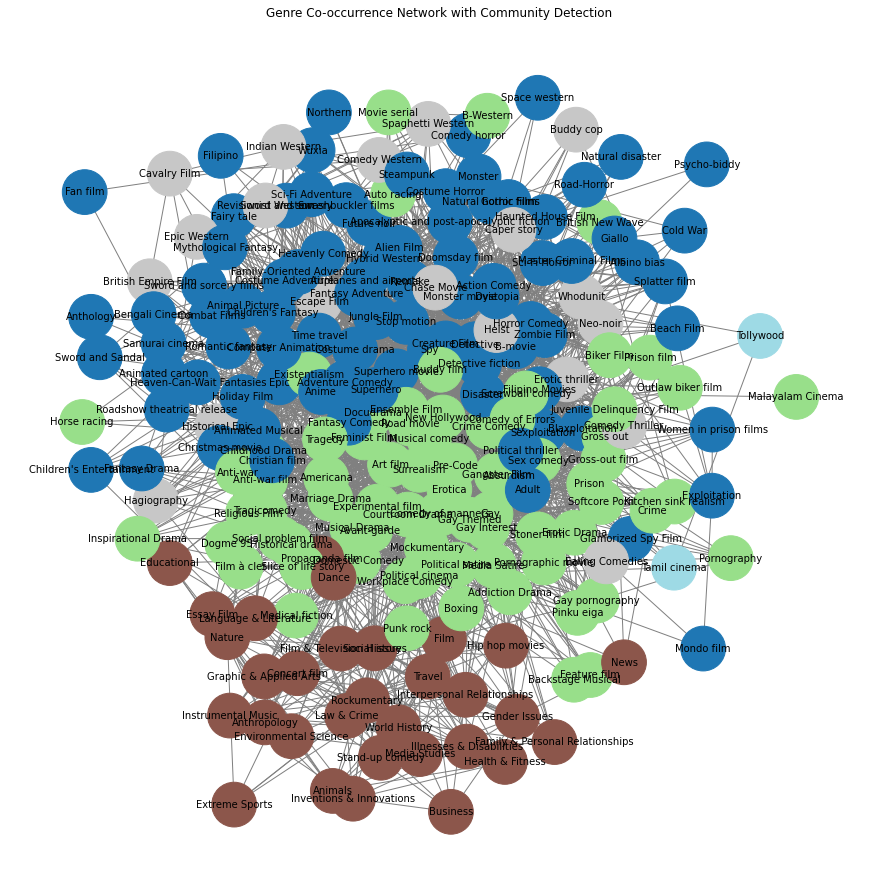

In [199]:
from networkx.algorithms import community

# Detect communities using the greedy modularity method
communities = community.greedy_modularity_communities(G_filtered)

# Assign colors based on the community each node belongs to
color_map = []
for node in G_filtered:
    for i, community in enumerate(communities):
        if node in community:
            color_map.append(i)

# Draw the graph with colored nodes
plt.figure(figsize=(12, 12))
nx.draw(G_filtered, pos, with_labels=True, node_size=2000, node_color=color_map, cmap=plt.cm.tab20, edge_color='gray', font_size=10)
plt.title('Genre Co-occurrence Network with Community Detection')
plt.show()



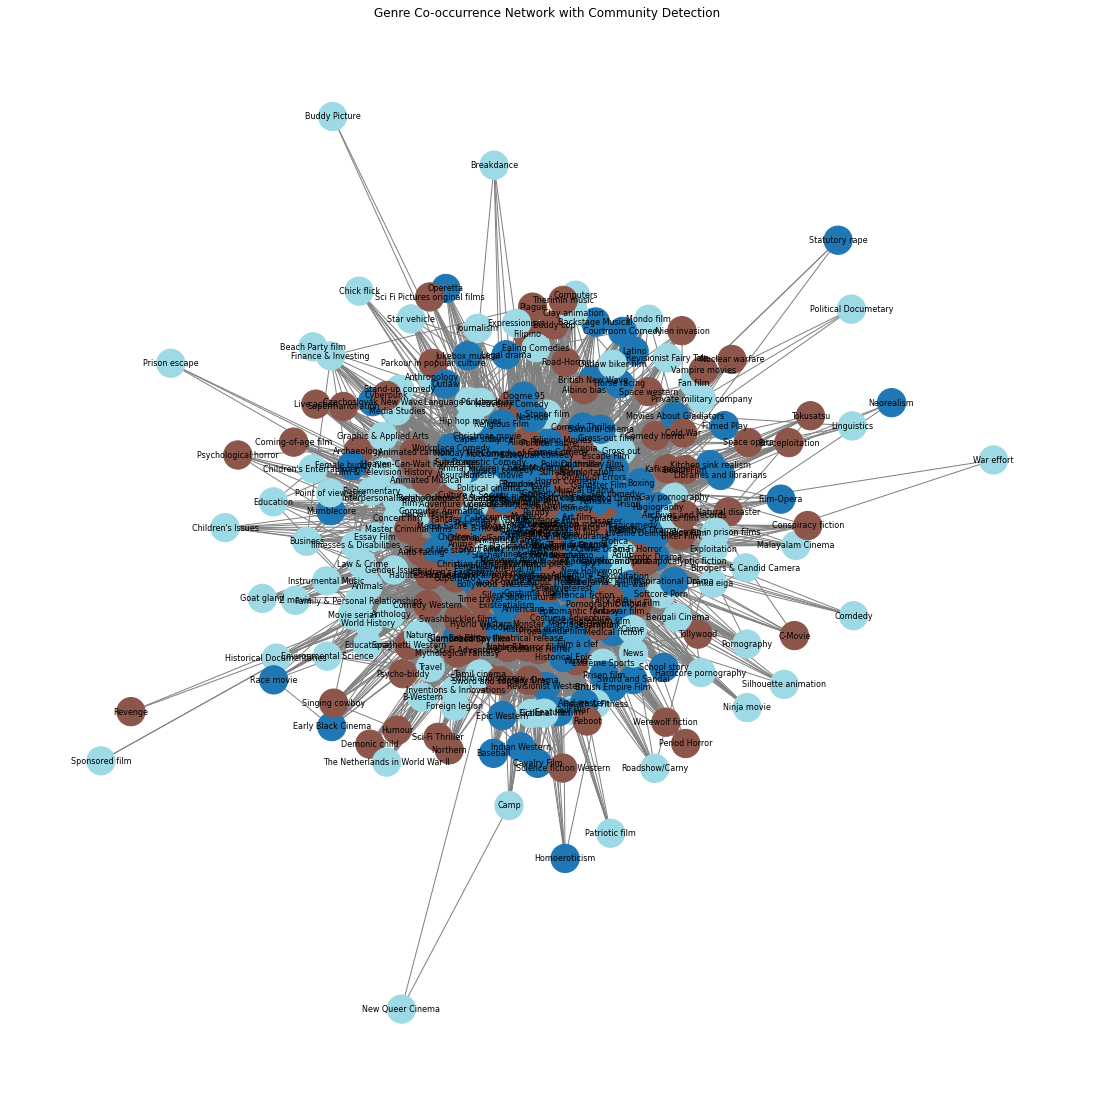

In [203]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import community

# Create pairs of genres for each movie to build a co-occurrence network
genre_pairs = []

# Iterate over each row in the cleaned 'Movie genres' column
for genres in movie_metadata['Movie genres'].dropna().str.split('|'):
    for i in range(len(genres)):
        for j in range(i + 1, len(genres)):
            genre_pairs.append((genres[i].strip(), genres[j].strip()))

# Create a NetworkX graph
G = nx.Graph()
G.add_edges_from(genre_pairs)

# Detect communities using the greedy modularity method
communities = list(community.greedy_modularity_communities(G))

# Assign colors to nodes based on their community
color_map = {}
for idx, comm in enumerate(communities):
    for node in comm:
        color_map[node] = idx

# Extract the color for each node from the color_map
node_colors = [color_map[node] for node in G.nodes()]

# Use a spring layout for better visualization
pos = nx.spring_layout(G, k=0.5)

# Draw the graph with nodes colored by their community
plt.figure(figsize=(15, 15))
nx.draw(G, pos, with_labels=True, node_size=800, node_color=node_colors, cmap=plt.cm.tab20, edge_color='gray', font_size=8)
plt.title('Genre Co-occurrence Network with Community Detection')
plt.show()


### We observe that it is difficult to have a valid interpretation due to the high number of movies, in order to add a more conclusive study, we can filter with the top 500 highest grossing movies and filter them by genre and have an interactive plot for better visualization

In [49]:
import pandas as pd
import networkx as nx
from pyvis.network import Network
from collections import Counter
from itertools import combinations
import random

# There are a lot of NaN in 'Movie box office revenue' so we filter them and rename to gross.
movie_metadata = movie_metadata.rename(columns={'Movie box office revenue': 'Gross'})
filtered_movies = movie_metadata.dropna(subset=['Gross'])

# Filter by top 500 grossing movies and calculate genre frequencies
top_500_movies = filtered_movies.nlargest(500, 'Gross')
all_genres = top_500_movies['Movie genres'].dropna().str.split('|').sum()
genre_counts = pd.Series(all_genres).value_counts()

# Define threshold for filtering
min_threshold = 10  
max_threshold = 500  

# Filter genres based on their occurrence count
filtered_genres = genre_counts[(genre_counts > min_threshold) & (genre_counts < max_threshold)].index

# Generate genre pairs
genre_pairs = []
for _, row in top_500_movies.iterrows():
    genres = row['Movie genres']
    if pd.isna(genres):
        continue
    genres_list = genres.split('|')
    genre_pairs.extend(list(combinations(genres_list, 2)))

# Filter genre pairs
filtered_genre_pairs = [pair for pair in genre_pairs if pair[0] in filtered_genres and pair[1] in filtered_genres]

# Count the occurrences of genre pairs
pair_counts = Counter(filtered_genre_pairs)

# Get the Top 50 Pairs
top_pairs = [pair for pair, count in pair_counts.most_common(50)]

# Initialize Pyvis Network
net = Network(notebook=True, height='1000px', width='100%', bgcolor='#222222', font_color='white')

# Assign unique colors to each genre
genre_colors = {genre: f'#{random.randint(0, 0xFFFFFF):06x}' for genre in filtered_genres}

# Add nodes with tooltips and increased size to reduce overlap
for genre in filtered_genres:
    size = int(genre_counts[genre] * 3)  
    color = genre_colors[genre]
    net.add_node(genre, label='', title=genre, size=size, color=color)  # Add tooltip using `title`

# Add edges for the top genre pairs
for genre1, genre2 in top_pairs:
    net.add_edge(genre1, genre2)

# Adjust Physics Settings to better control nodes
net.toggle_physics(True)

# Settings for bringing outer nodes closer and pushing nodes with many connections further
net.repulsion(
    node_distance=1000,  
    central_gravity=0.05,  
    spring_length=1500,  
    spring_strength=0.2  
)

net.barnes_hut(
    gravity=-30000,  
    central_gravity=0.3,  
    spring_length=100,  
    spring_strength=0.01 
)

# Interactive Visualization
net.show("top_genre_collaboration_filtered_adjusted.html")


top_genre_collaboration_filtered_adjusted.html
